# Experiment 6

## New scenario: Suikawari
https://en.wikipedia.org/wiki/Suikawari

I made a new scenario 'suikawari' and checked its behavior.

### Rule

### Results

In [1]:
%matplotlib inline
import os
import os.path as osp
import re
import glob
from IPython.display import HTML
from IPython.display import display
plt.rcParams["font.size"] = 16

exp_dir = '../exp_results/exp6_180331'
par_dir = '../params/'

def play_linked_video(each_exp_dir, fn_video, width=500, height=300):
    fn_video = _get_linked_video(each_exp_dir, fn_video)
    return _play_video(fn_video, width, height)

def _get_linked_video(each_exp_dir, fn_video):
    link_dir = osp.join('./videos', osp.basename(each_exp_dir))
    if osp.lexists(link_dir):
        os.remove(link_dir)
    os.symlink(osp.abspath(each_exp_dir), link_dir)
    fn_video = osp.join(link_dir, 'videos/%s' % fn_video)
    return fn_video

def _play_video(fn_video, width=500, height=300):
    print(fn_video)
    return HTML("""
    <video width="%d" height="%d" controls>
      <source src="%s" type="video/mp4">
    </video>""" % (width, height, fn_video))

def get_exp_dir(exp_dir, scenario):
    for fn in glob.glob(osp.join(exp_dir, '*')):
        if re.search(scenario + '__', fn):
            return fn

def get_scenario_df(exp_dir, scenario, fn_rewards):
    each_exp_dir = get_exp_dir(exp_dir, scenario)
    fn_lc = osp.join(each_exp_dir, 'learning_curves', fn_rewards)
    df_lc = pd.read_csv(fn_lc, index_col=False)
    return df_lc
    
def plot_each_lc(scenario):
    fn_lcs = ['rewards.csv', 'agents_rewards.csv']
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    for i, fn_rew in enumerate(fn_lcs):
        df_lc = get_scenario_df(exp_dir, scenario, fn_rew)
        df_lc.plot(x='step', style='-o', fontsize=16, ax=axes[i], title=scenario, alpha=0.5)

def plot_each_lc2(each_exp_dir):
    fn_lcs = ['rewards.csv', 'rewards.csv', 'agents_rewards.csv']
    
    fig, axes = plt.subplots(1, 3, figsize=(21, 5))
    for i, fn_rew in enumerate(fn_lcs):
        fn_lc = osp.join(each_exp_dir, 'learning_curves', fn_rew)
        df_lc = pd.read_csv(fn_lc, index_col=False)
        df_lc.columns = [coln.strip() for coln in df_lc.columns]
        if i == 0:
            df_lc['step_per_epi'] = df_lc[['step']].diff().values / df_lc[['episode']].diff().values
            df_lc.plot(x='episode', y='step_per_epi', style='-o', fontsize=12, 
                               ax=axes[i], title=osp.basename(each_exp_dir), alpha=0.5)
        else:
            del df_lc['step']
            df_lc.plot(x='episode', style='-o', fontsize=12, ax=axes[i], title=osp.basename(each_exp_dir), alpha=0.5)
    #     break

def action_space(scenario):
    from multiagent.environment import MultiAgentEnv
    import multiagent.scenarios as scenarios
    fn = osp.join('../../../multiagent-particle-envs/multiagent/scenarios/%s.py' % scenario)
    scenario = scenarios.load(fn).Scenario()
    world = scenario.make_world()
    env = MultiAgentEnv(world, scenario.reset_world, scenario.reward, scenario.observation)
    print(env.action_space)

In [2]:
def _make_dic():
    import string
    abc = string.ascii_uppercase
    if False:
        dic = dict(zip(abc, range(1, len(abc)+1)))
        dic['_'] = 0
    else:
        dic = dict(zip(abc, range(0, len(abc))))
    return dic

def to_case_val(case):
    dic = _make_dic()
    return dic[case]

def to_val_case(val):
    dic = _make_dic()
    dic_rev = dict([(v, k) for k, v in dic.items()])
    return dic_rev[val]

def get_df_messages2(fn_video):
    fn_message = fn_video.replace('.mp4', '_messages.csv')
    df_msg = pd.read_csv(fn_message)
    for coln in df_msg.columns[:-2]:
        if np.all(df_msg[coln] == '_'):
            del df_msg[coln]
        else:
            df_msg[coln] = df_msg[coln].apply(to_case_val)
    return df_msg

def plot_messages2(fn_video):
    df_msg = get_df_messages2(fn_video)
    each_epis = sorted(df_msg.episode.unique())
    fig, axes = plt.subplots(1, len(each_epis), figsize=(7*len(each_epis), 5), sharey=True)

    yticks = range(int(df_msg.iloc[:, :-2].values.max()) + 1)
    for i, i_epi in enumerate(each_epis):
        ax = axes[i]
        df_msg.loc[df_msg.episode==i_epi, df_msg.columns != 'episode']\
            .plot(x='step', style='-o', ax=ax,
                     alpha=0.5, title='i_epi=%d' % i_epi)
        ax.set_yticks(yticks)
        ax.set_yticklabels([to_val_case(v) for v in yticks])
    plt.subplots_adjust(wspace=0.05, hspace=0)

In [10]:
def plot_actions(epi, fn_video_template, n_episdoes=3):
    n_each_step = 50
    
    n_dim = 5
    colns = ['act%d' % i for i in range(n_dim)]
    dic_act = dict(zip(colns, list(range(n_dim))))
    ylabels = ['char', 'action']
    
    fn_video = _get_linked_video(each_exp_dir, fn_video_template.format(epi))
    df0 = pd.read_csv(fn_video.replace('.mp4', '_actions_agent0.csv'))
    df1 = pd.read_csv(fn_video.replace('.mp4', '_actions_agent1.csv'))

    fig, axes = plt.subplots(2, 1, figsize=(24, 8), sharex=True)
    plt.subplots_adjust(hspace=0)
    epis = [i+1 for i in range(n_episdoes)]
    for i, df in enumerate([df0, df1]):
        ax, ylabel = axes[i], ylabels[i]
        df.loc[df.episode.isin(epis), colns].rename(columns=dic_act).idxmax(axis=1).plot(style='-o', ax=ax)
        ax.set_ylabel(ylabels[i])
        if i == 0:
            yticks = list(range(n_dim))
            ax.set_yticks(yticks)
            ax.set_yticklabels([to_val_case(v) for v in yticks])
        for i in range(n_episdoes):
            end_epi = (i + 1) * n_each_step - 1
            ax.axvline(end_epi, color='r', ls='--')

## 6-1

#### action (5 dimension)
- 1: right
- 2: left
- 3: up
- 4: down
- 0: same as the previous action



## 6-1-1

#### speaker's char and meaning
- A: down
- B: left
- C: stay (you are around the goal!)
- D: right
- E: up

ぴたっと止まらないのは、Cを受け取っても、それがどこに向けばよいのかがわからないから。
おそらくrandomに振る舞うのだろう。
すくなくとも直前のcharが必要

None

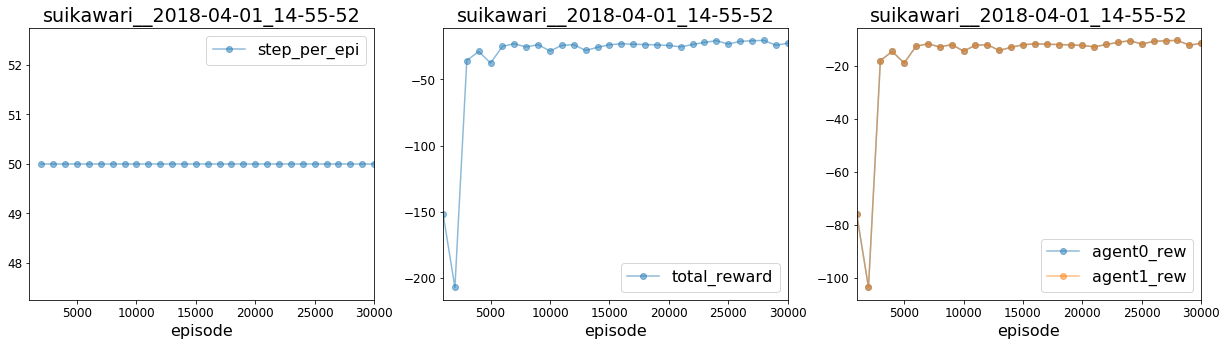

./videos/suikawari__2018-04-01_14-55-52/videos/video-30000.mp4


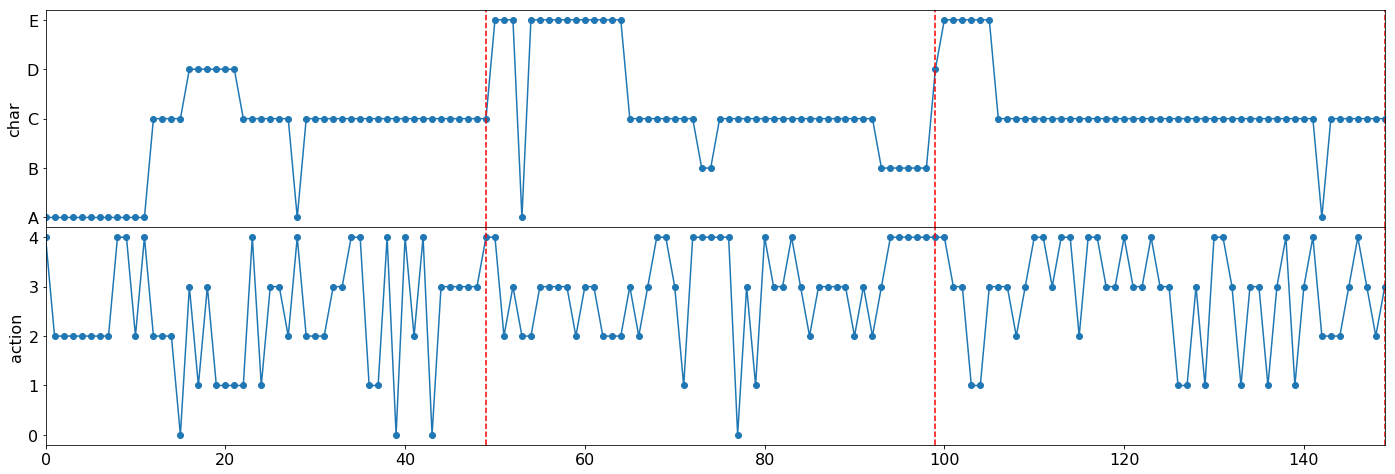

In [4]:
each_exp_dir= 'suikawari__2018-04-01_14-55-52'
fn_video_template = 'video-{}.mp4'
epis = [30000]

each_exp_dir = osp.join(exp_dir, each_exp_dir)
display(plot_each_lc2(each_exp_dir))
plt.show()

for epi in epis:
    fn_video = fn_video_template.format(epi)
    display(play_linked_video(each_exp_dir, fn_video))
    plot_actions(epi, fn_video_template)
    plt.show()

None

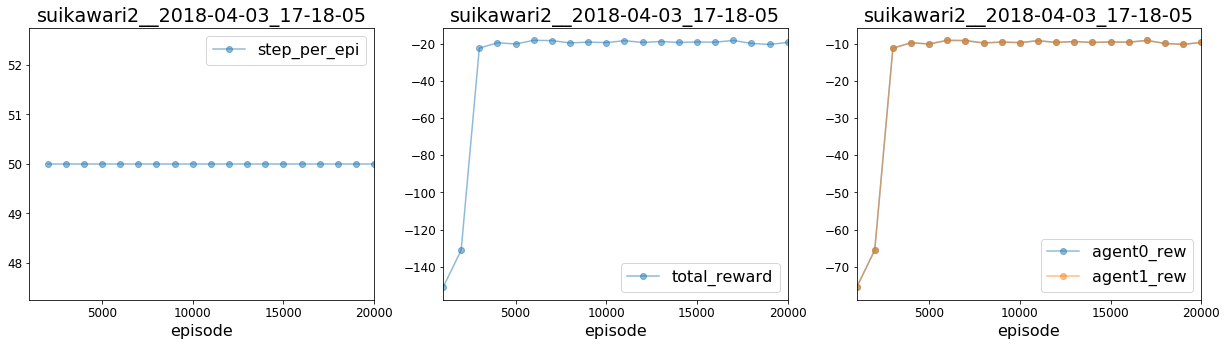

./videos/suikawari2__2018-04-03_17-18-05/videos/video-20000.mp4


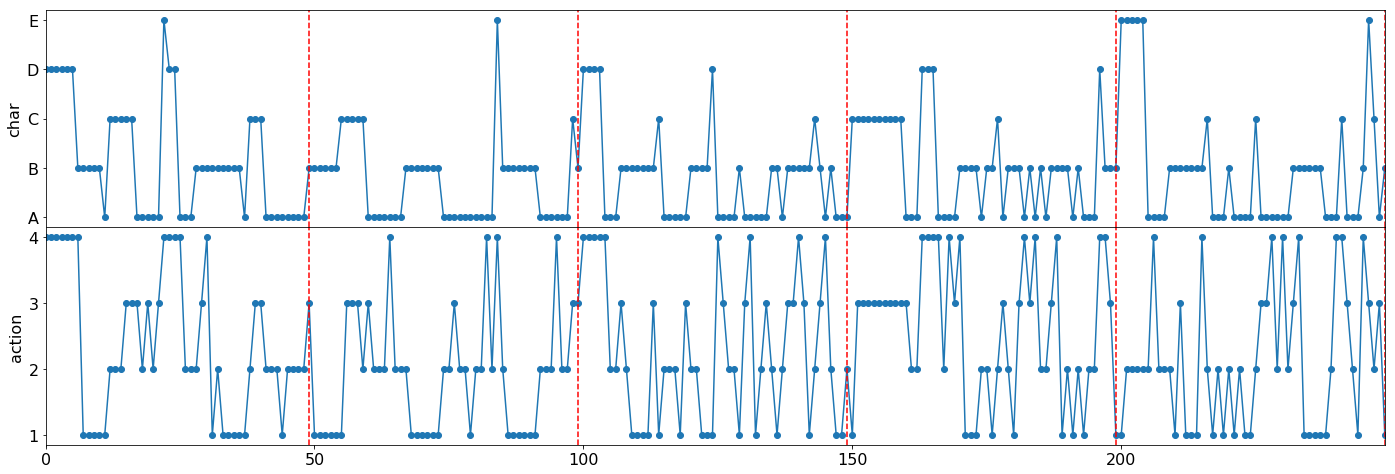

In [11]:
each_exp_dir= 'suikawari2__2018-04-03_17-18-05'
fn_video_template = 'video-{}.mp4'
epis = [20000]

each_exp_dir = osp.join(exp_dir, each_exp_dir)
display(plot_each_lc2(each_exp_dir))
plt.show()

for epi in epis:
    fn_video = fn_video_template.format(epi)
    display(play_linked_video(each_exp_dir, fn_video))
    plot_actions(epi, fn_video_template, 5)
    plt.show()

#### action (5 dimension)
- 1: right
- 2: left
- 3: up
- 4: down
- 0: same as the previous action

- E: left & down
- B: right
- C up
- D down
- A stay的な？

6-1-1より改善されている
ただし、きれいにはわかれなかった。
goalの近くにくると、AとBが現れる（主にAの方が優勢）
Bは直前の値がrightだと、right
Aは直前の行動と異なる行動をとる事がおおい
ただし完全にはrandomではなく、left優勢。そのためrightのBが補正として入っているようだ

## 6-2